# Rainfall across the Australian wheatbelt

The Australian Bureau of Agricultural and Resource Economics and Sciences (ABARES)
defines a set of Australian broadacre zones and regions.

The last four very dry years across the "wheat-sheep" region
line up really well with the last four times Australia had to import grain
(1994-95, 2002-03, 2006-07, 2019-20; see
[ABC](https://www.abc.net.au/news/rural/2019-05-15/australia-approves-grain-imports/11113320),
[Guardian](https://www.theguardian.com/australia-news/2019/may/15/australia-to-import-wheat-for-first-time-in-12-years-as-drought-eats-into-grain-production)).

In [1]:
wheat_import_years = [1994, 2002, 2006, 2019]

In [2]:
import os
import sys
sys.path.append('/home/599/dbi599/unseen/unseen')

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
from IPython.display import Image
import cftime

import fileio
import time_utils

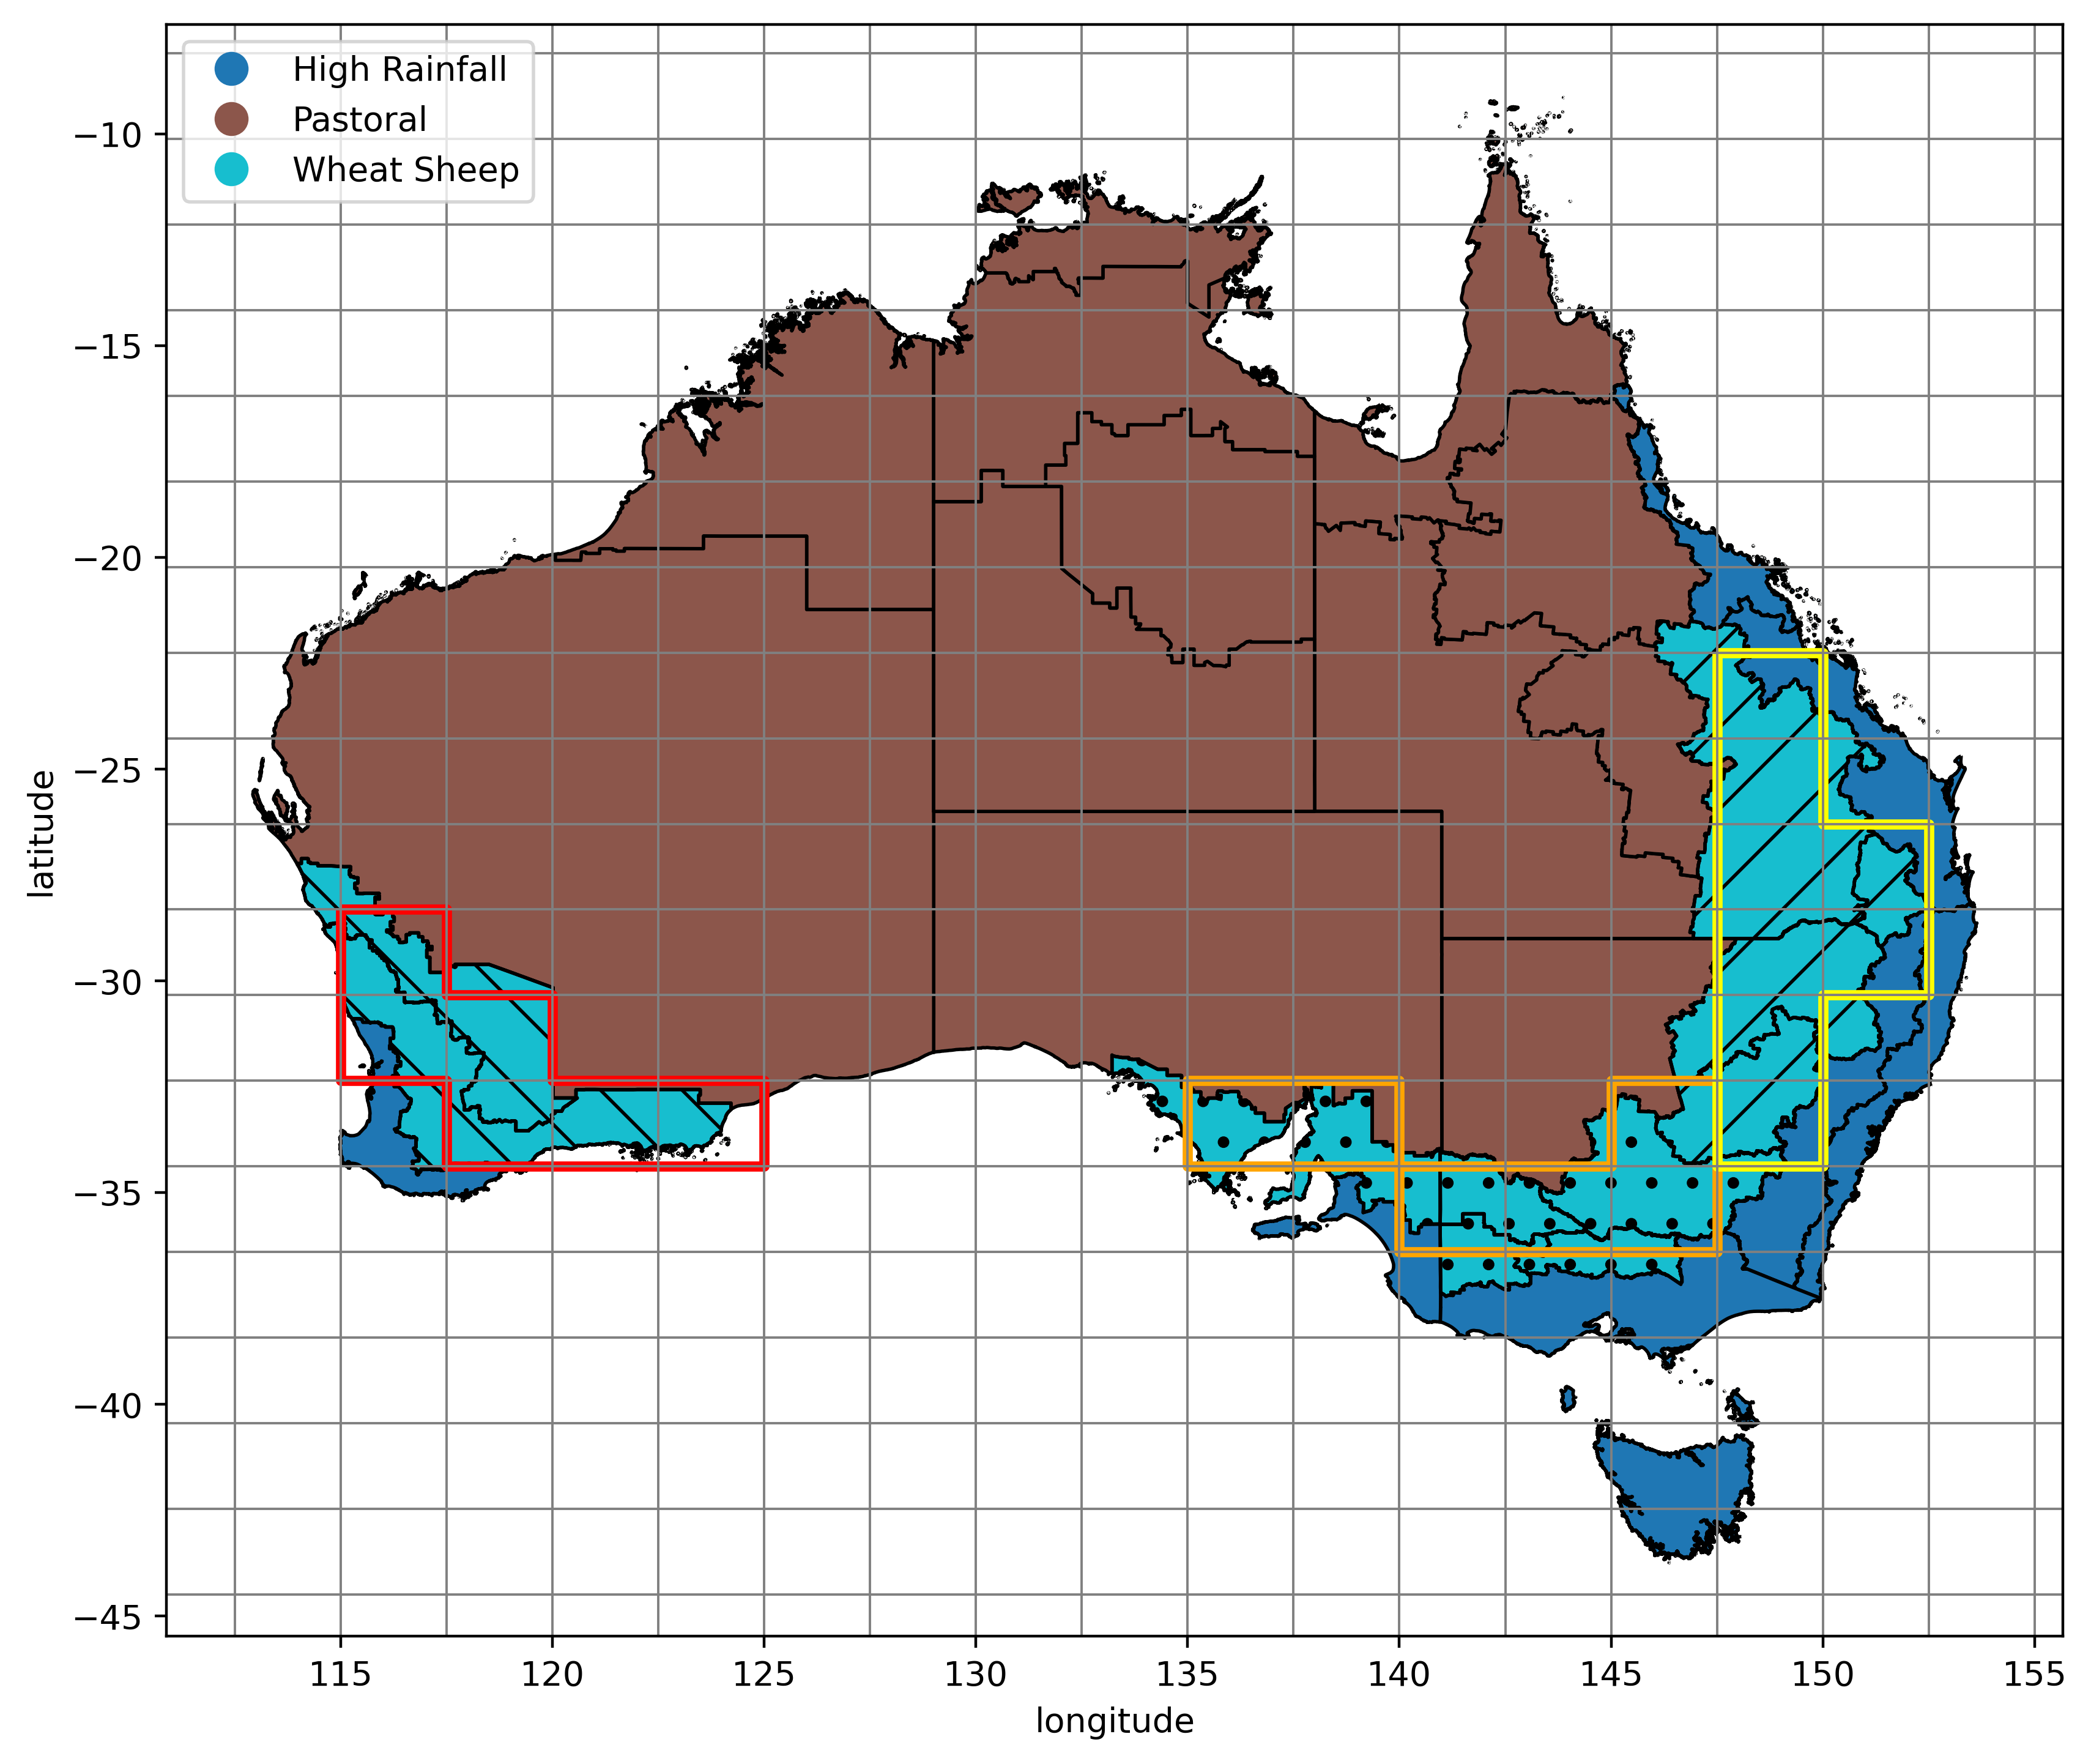

In [3]:
Image(filename='/g/data/xv83/dbi599/ag/figures/ag_regions.png')

In [4]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [5]:
# Parameters
agcd_file = (
    "/g/data/xv83/dbi599/ag/data/pr_agcd_1900-2019_A-DEC-mean_wheat-sheep-mean.zarr.zip"
)
cafe_file = "/g/data/xv83/dbi599/ag/data/pr_cafe-c5-d60-pX-f6_19811101-20201101_A-DEC-mean_wheat-sheep-mean.zarr.zip"
cafe_bc_file = "/g/data/xv83/dbi599/ag/data/pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
fidelity_file = "/g/data/xv83/dbi599/ag/data/ks-test_pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-mean_bias-corrected-agcd-additive.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/ag/figures/independence-test_pr_cafe-c5-d60-pX-f6_19900501-20191101_A-DEC-mean_wheat-sheep-south-east-mean_bias-corrected-agcd-additive.png"
region = "south-east"


In [6]:
# Required parameters
assert 'region' in locals(), "Must provide an AGCD data file (papermill option -p region [all south-west south-east or north-east])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(cafe_file), "Must provide an CAFE data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(cafe_bc_file), "Must provide an CAFE bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(fidelity_file), "Must provide an fidelity test file (papermill option -p fidelity_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [7]:
agcd_ds = fileio.open_file(agcd_file)

In [8]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 4, time: 120)
Coordinates:
  * region   (region) <U10 'south-west' 'south-east' 'north-east' 'all'
  * time     (time) object 1900-12-31 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    pr       (time, region) float64 dask.array<chunksize=(1, 4), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.6, ACDD-1.3
    acknowledgment:            The Australian Government, Bureau of Meteorolo...
    agcd_version:              AGCD v2.0.0 Snapshot (1900-01-01 to 2020-05-31)
    analysis_components:       total: the gridded accumulation of rainfall.
    attribution:               Data should be cited as : Australian Bureau of...
    cdm_data_type:             Grid
    ...                        ...
    summary:                   The monthly rainfall data represents the amoun...
    time_coverage_end:         1900-12-31T00:00:00
    time_coverage_start:       1900-01-01T00:00:00
    title:                     Interpolated Rain Gauge Precipitation
    url:                       http://www.bom.gov.au/climate/
    uuid:                      43596dc1-c56e-42a2-ba87-4e3b726a6e60

In [9]:
agcd_ds['pr'] = agcd_ds['pr'] * 365
agcd_ds['pr'].attrs['units'] = 'mm yr-1'

In [10]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df[region] = agcd_ds['pr'].sel(region=region).values

In [11]:
mean_rainfall = agcd_df[region].mean()
print(mean_rainfall)

373.4834073371833


In [12]:
years_list = list(years)
nyears = len(years_list)
colors = ['tab:blue'] * nyears
for year in wheat_import_years:
    index = years_list.index(year)
    colors[index] = 'tab:red'

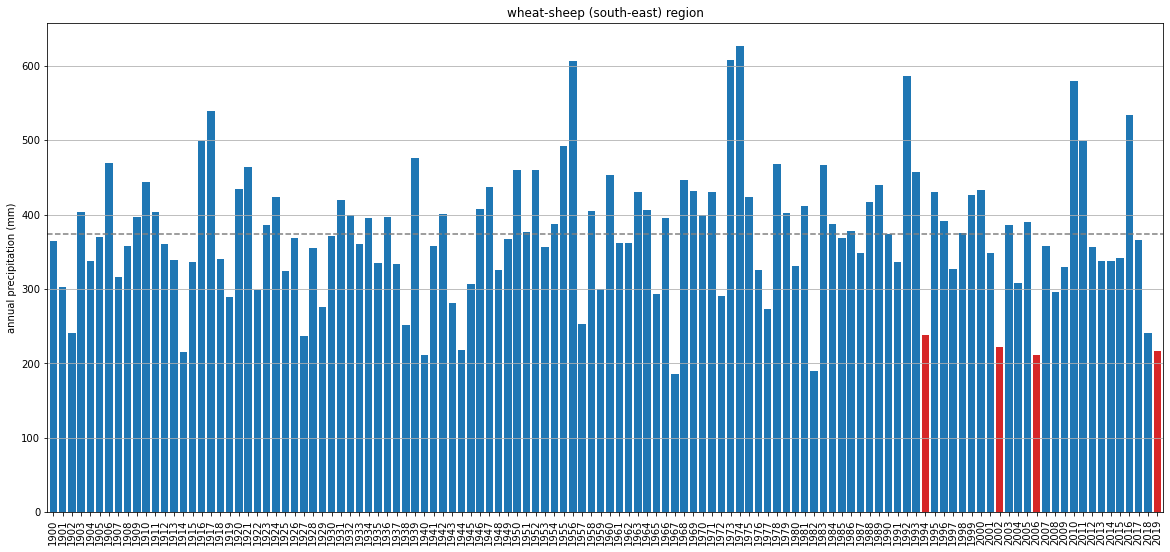

In [13]:
agcd_df[region].plot.bar(figsize=[20, 9], width=0.8, color=colors)
plt.axhline(mean_rainfall, color='0.5', linestyle='--')
plt.ylabel('annual precipitation (mm)')
plt.title(f'wheat-sheep ({region}) region')
plt.grid(axis='y')
plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [14]:
ranked_years = agcd_df[region].sort_values()
ranked_years.head(n=10)

1967    185.704308
1982    190.315645
2006    211.398937
1940    211.599354
1914    215.075344
2019    217.078133
1944    218.394825
2002    221.544753
1927    236.348828
1994    237.807916
Name: south-east, dtype: float64

In [15]:
def year_in_context(ranked_years_df, year):
    """Put a given year in context"""
    
    nyears = len(ranked_years_df)
    rank = ranked_years_df.index.get_loc(year) + 1
    percentile = (rank / nyears) * 100
    return_period = nyears / rank
    
    print(f'# {year} statistics:')
    print(f'{rank} in {nyears} year event')
    print(f'{percentile:.1f}% percentile')
    print(f'{return_period:.0f} year return period')
    print(' ')

In [16]:
for year in wheat_import_years:
    year_in_context(ranked_years, year)

# 1994 statistics:
10 in 120 year event
8.3% percentile
12 year return period
 
# 2002 statistics:
8 in 120 year event
6.7% percentile
15 year return period
 
# 2006 statistics:
3 in 120 year event
2.5% percentile
40 year return period
 
# 2019 statistics:
6 in 120 year event
5.0% percentile
20 year return period
 


In [17]:
all_regions = ['all', 'south-west', 'south-east', 'north-east']
for comparison_region in all_regions:
    if not region == comparison_region:
        corr = xr.corr(agcd_ds['pr'].sel(region=region),
                       agcd_ds['pr'].sel(region=comparison_region),
                       dim='time').values
        print(f'{region} vs {comparison_region}: {corr}')

south-east vs all: 0.8626583938896787


south-east vs south-west: 0.4490696208442514


south-east vs north-east: 0.6702589616396489


## Model ensemble

In [18]:
cafe_ds = fileio.open_file(cafe_file)
cafe_bc_ds = fileio.open_file(cafe_bc_file)

In [19]:
cafe_bc_ds['pr'].attrs['units']

'mm d-1'

In [20]:
cafe_ds['pr'] = cafe_ds['pr'] * 365
cafe_ds['pr'].attrs['units'] = 'mm yr-1'

cafe_bc_ds['pr'] = cafe_bc_ds['pr'] * 365
cafe_bc_ds['pr'].attrs['units'] = 'mm yr-1'

### Bias correction and fidelity testing

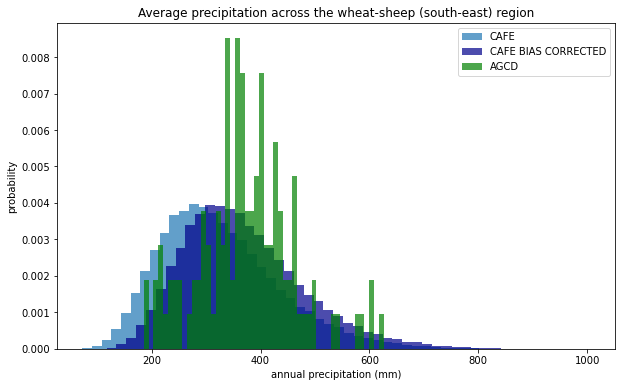

In [21]:
fig = plt.figure(figsize=[10, 6])
cafe_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE', alpha=0.7)
cafe_bc_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='CAFE BIAS CORRECTED', facecolor='darkblue', alpha=0.7)
agcd_ds.sel(region=region)['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('annual precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Average precipitation across the wheat-sheep ({region}) region')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_histogram_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

In [22]:
fidelity_ds = xr.open_zarr(fidelity_file)

In [23]:
fidelity_ds.sel(region=region)['pval'].values

array([0.32041378, 0.49954684, 0.4891986 , 0.43043753, 0.32041378,
       0.2716199 , 0.31247117, 0.2836972 , 0.25307491])

These are the p-values for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

### Independence testing

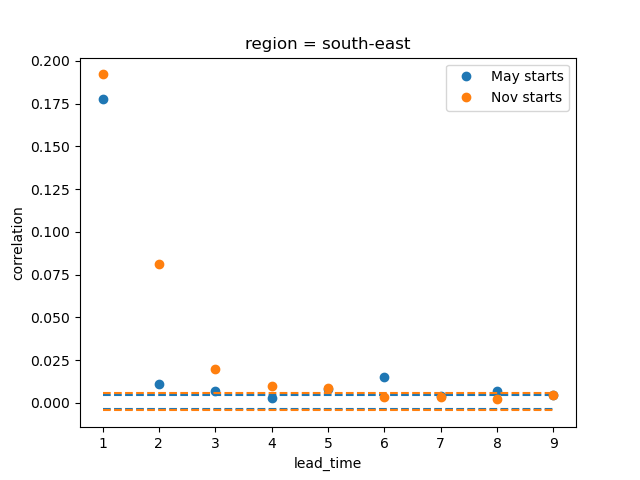

In [24]:
Image(filename=independence_plot)

### Exceedance curves

In [25]:
cafe_bc_ds_stacked = cafe_bc_ds.sel(region=region, lead_time=slice(3, None))['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [26]:
cafe_bc_ds_stacked.shape

(44928,)

In [27]:
cafe_bc_ds_stacked = time_utils.select_time_period(cafe_bc_ds_stacked, ['1990-01-01', '2019-12-31'])

In [28]:
cafe_bc_ds_stacked = cafe_bc_ds_stacked.dropna(dim='sample')

In [29]:
cafe_bc_ds_stacked.shape

(34272,)

In [30]:
def calc_exceedance(ds_stacked):
    """Calculate exceedance"""
    
    data = ds_stacked.compute()
    sorted_data = np.sort(data, axis=None)
    exceedance = 1.-np.arange(1.,len(data) + 1.)/len(data)
    
    return sorted_data, exceedance

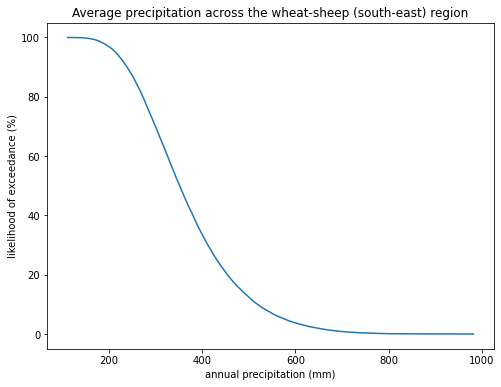

In [31]:
sorted_data, exceedance = calc_exceedance(cafe_bc_ds_stacked)

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, exceedance * 100)
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of exceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
plt.show()

In [32]:
def event_in_context(data, threshold, year, direction):
    """Put an event in context
    
    Args:
      data (np.ndarray)
      threshold (float) : event threshold
      year (int) : year that the event occured in the observations
      direction (str) : 'less' or 'greater' than
    """

    n_population = len(data)
    if direction == 'less':
        n_events = np.sum(data < threshold)
    elif direction == 'greater':
        n_events = np.sum(data > threshold)
    else:
        raise ValueError("""direction must be 'less' or 'greater'""")
    percentile = (n_events / n_population) * 100
    return_period = 1 / (percentile / 100)
    
    print(f'# {year} ({threshold:.1f}mm) statistics:')
    print(f'{n_events} in {n_population} year event')
    print(f'{percentile:.2f}% percentile')
    print(f'{return_period:.0f} year return period')
    print(' ')

#### Full 1990-2019 time period

# 1994 (237.8mm) statistics:
3323 in 34272 year event
9.70% percentile
10 year return period
 
# 2002 (221.5mm) statistics:
2144 in 34272 year event
6.26% percentile
16 year return period
 
# 2006 (211.4mm) statistics:
1540 in 34272 year event
4.49% percentile
22 year return period
 
# 2019 (217.1mm) statistics:
1871 in 34272 year event
5.46% percentile
18 year return period
 


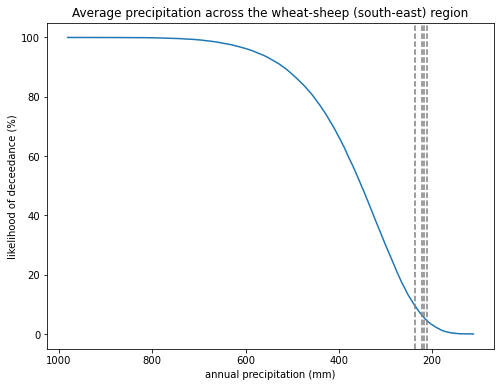

In [33]:
for year in wheat_import_years:
    event_in_context(sorted_data, ranked_years[year], year, 'less')

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()
ax.plot(sorted_data, 100 - (exceedance * 100))
ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')

for year in wheat_import_years:
    ax.axvline(ranked_years[year], color='0.5', linestyle='--')

plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_deceedence_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)

#### By decade

1990-1994


# 1994 (237.8mm) statistics:
410 in 5472 year event
7.49% percentile
13 year return period
 


# 2002 (221.5mm) statistics:
277 in 5472 year event
5.06% percentile
20 year return period
 


# 2006 (211.4mm) statistics:
191 in 5472 year event
3.49% percentile
29 year return period
 


# 2019 (217.1mm) statistics:
234 in 5472 year event
4.28% percentile
23 year return period
 


1995-1999


# 1994 (237.8mm) statistics:
538 in 5760 year event
9.34% percentile
11 year return period
 


# 2002 (221.5mm) statistics:
332 in 5760 year event
5.76% percentile
17 year return period
 


# 2006 (211.4mm) statistics:
242 in 5760 year event
4.20% percentile
24 year return period
 


# 2019 (217.1mm) statistics:
293 in 5760 year event
5.09% percentile
20 year return period
 


2000-2004


# 1994 (237.8mm) statistics:
559 in 5760 year event
9.70% percentile
10 year return period
 


# 2002 (221.5mm) statistics:
367 in 5760 year event
6.37% percentile
16 year return period
 


# 2006 (211.4mm) statistics:
242 in 5760 year event
4.20% percentile
24 year return period
 


# 2019 (217.1mm) statistics:
318 in 5760 year event
5.52% percentile
18 year return period
 


2005-2009


# 1994 (237.8mm) statistics:
601 in 5760 year event
10.43% percentile
10 year return period
 


# 2002 (221.5mm) statistics:
375 in 5760 year event
6.51% percentile
15 year return period
 


# 2006 (211.4mm) statistics:
270 in 5760 year event
4.69% percentile
21 year return period
 


# 2019 (217.1mm) statistics:
323 in 5760 year event
5.61% percentile
18 year return period
 


2010-2014


# 1994 (237.8mm) statistics:
599 in 5760 year event
10.40% percentile
10 year return period
 


# 2002 (221.5mm) statistics:
384 in 5760 year event
6.67% percentile
15 year return period
 


# 2006 (211.4mm) statistics:
282 in 5760 year event
4.90% percentile
20 year return period
 


# 2019 (217.1mm) statistics:
339 in 5760 year event
5.89% percentile
17 year return period
 


2015-2019


# 1994 (237.8mm) statistics:
616 in 5760 year event
10.69% percentile
9 year return period
 


# 2002 (221.5mm) statistics:
409 in 5760 year event
7.10% percentile
14 year return period
 


# 2006 (211.4mm) statistics:
313 in 5760 year event
5.43% percentile
18 year return period
 


# 2019 (217.1mm) statistics:
364 in 5760 year event
6.32% percentile
16 year return period
 


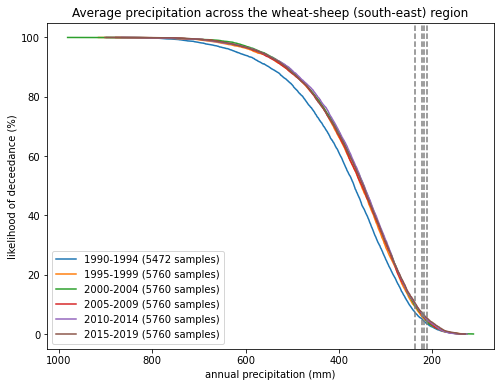

In [34]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot()

for start_year in [1990, 1995, 2000, 2005, 2010, 2015]:
    end_year = start_year + 4
    start_date = f'{start_year}-01-01'
    end_date = f'{end_year}-12-31'
    ds_selection = time_utils.select_time_period(cafe_bc_ds_stacked, [start_date, end_date])
    ds_selection = ds_selection.dropna('sample')
    sorted_data, exceedance = calc_exceedance(ds_selection)
    n_years = len(sorted_data)
    label = f'{start_year}-{end_year} ({n_years} samples)'
    ax.plot(sorted_data, 100 - (exceedance * 100), label=label)
    
    print(f'{start_year}-{end_year}')
    for year in wheat_import_years:
        event_in_context(ds_selection.values, ranked_years[year], year, 'less')

ax.invert_xaxis()
ax.set_title(f'Average precipitation across the wheat-sheep ({region}) region')
ax.set_ylabel('likelihood of deceedance (%)')
ax.set_xlabel('annual precipitation (mm)')
ax.legend()
for year in wheat_import_years:
    ax.axvline(ranked_years[year], color='0.5', linestyle='--')

plt.savefig(f'/g/data/xv83/dbi599/ag/figures/wheat_sheep_precip_deceedence-by-pentad_{region}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)